# HOG

In [42]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

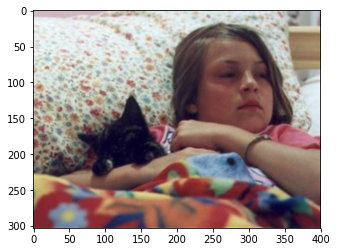

In [45]:
img = cv2.imread('../data/train/cat/cat.6.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb, cmap = 'gray', interpolation = 'bicubic')

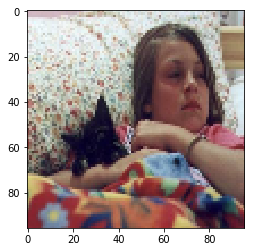

In [46]:
img_resize = cv2.resize(img, (96, 96))
img_resize_rgb = cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB)
plt.imshow(img_resize_rgb, cmap = 'gray')

In [47]:
winSize = (96, 96)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
hog_values = hog.compute(img_resize)

### Compute PCA for a number of images' features

In [82]:
winSize = (96, 96)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

path = '../data/train'
cat_path = os.path.join(path, 'cat')
dog_path = os.path.join(path, 'dog')
X_cat = []
X_dog = []
batch_size = 1000
i = 0

out_path = '../data/train_hog'
out_i = 0

cat_files = os.listdir(cat_path)
dog_files = os.listdir(dog_path)
while i < len(cat_files):
    while i % (batch_size / 2) != 0 or len(X_cat) == 0:
        cat_file = cat_files[i]
        cat_filepath = os.path.join(cat_path, cat_file)
        cat_img = cv2.imread(cat_filepath)
        cat_img_resize = cv2.resize(cat_img, winSize)
        cat_hog = hog.compute(cat_img_resize)
        X_cat.append(cat_hog.reshape(1, -1))
        
        dog_file = dog_files[i]
        dog_filepath = os.path.join(dog_path, dog_file)
        dog_img = cv2.imread(dog_filepath)
        dog_img_resize = cv2.resize(dog_img, winSize)
        dog_hog = hog.compute(dog_img_resize)
        X_dog.append(dog_hog.reshape(1, -1))
        
        i += 1
        if i % 200 == 0: print(i)
        
    if len(X_cat) > 0:
        out_i += 1
        X = np.concatenate(X_cat + X_dog, axis=0)
        
        out_filepath = os.path.join(out_path, 'hog_{}.npy'.format(out_i))
        np.save(out_filepath, X)
        
        X_cat = []
        X_dog = []
        print('{} samples saved'.format(i * 2))
else:
    y = np.concatenate([np.zeros((int(batch_size / 2), 1)), 
                        np.ones((int(batch_size / 2), 1))], axis=0)
    out_filepath = os.path.join(out_path, 'labels.npy'.format(out_count))
    np.save(out_filepath, y)

200
400
1000 samples saved
600
800
1000
2000 samples saved
1200
1400
3000 samples saved
1600
1800
2000
4000 samples saved
2200
2400
5000 samples saved
2600
2800
3000
6000 samples saved
3200
3400
7000 samples saved
3600
3800
4000
8000 samples saved
4200
4400
9000 samples saved
4600
4800
5000
10000 samples saved
5200
5400
11000 samples saved
5600
5800
6000
12000 samples saved
6200
6400
13000 samples saved
6600
6800
7000
14000 samples saved
7200
7400
15000 samples saved
7600
7800
8000
16000 samples saved
8200
8400
17000 samples saved
8600
8800
9000
18000 samples saved
9200
9400
19000 samples saved
9600
9800
10000
20000 samples saved
10200
10400
21000 samples saved
10600
10800
11000
22000 samples saved
11200
11400
23000 samples saved
11600
11800
12000
24000 samples saved
12200
12400
25000 samples saved


### Use PCA to pick the number of features to reduce to
Target: 95% retained variance

In [56]:
from sklearn.decomposition import IncrementalPCA
path = '../data/train_hog'
pca = IncrementalPCA(batch_size=2000)
count = 0
X = []
for file in os.listdir(path):
    if file.endswith('gz'):
        filepath = os.path.join(out_path, file)
        X.append(np.loadtxt(filepath))
        count += 1
        print('{} files read'.format(count))
        if len(X) >= 2:
            X = np.concatenate(X, axis = 0)
            pca = pca.partial_fit(X)
            X = []
        
else:
    if len(X) > 0:
        X = np.concatenate(X, axis = 0)
        pca = pca.partial_fit(X)
        X = []

1 files read


/home/mingkaid/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:293: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/mingkaid/.virtualenvs/cv/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2 files read
3 files read
4 files read
5 files read
6 files read
7 files read
8 files read
9 files read
10 files read
11 files read
12 files read
13 files read
14 files read
15 files read
16 files read
17 files read
18 files read
19 files read
20 files read
21 files read
22 files read
23 files read
24 files read
25 files read
26 files read


In [68]:
explained_thres = 0.95
num_components = int(np.argwhere(np.cumsum(explained_var) > explained_thres)[0]) + 1

In [71]:
sample_mean = pca.mean_
sample_eigenvec = pca.components_[:num_components, :]

In [83]:
from sklearn.externals import joblib
out_path = '../data/train_hog'
out_filepath = os.path.join(out_path, 'pca.joblib')
joblib.dump(pca, out_filepath)

['../data/train_hog/pca.joblib']

In [90]:
test_X = np.load('../data/train_hog/hog_1.npy')
test_X_compressed = cv2.PCAProject(test_X, sample_mean.reshape(1, -1), sample_eigenvec)

### Use SVC with RBF kernel to cross-validate model

In [3]:
from sklearn.externals import joblib
pca = joblib.load('../data/train_hog/pca.joblib')
explained_thres = 0.95
num_components = int(np.argwhere(np.cumsum(pca.explained_variance_ratio_) > explained_thres)[0]) + 1
pca_mean = pca.mean_.reshape(1, -1)
pca_eigenvectors = pca.components_[:num_components, :]

In [54]:
in_path = '../data/train_hog'
X = []
Y = []
in_filepath = os.path.join(in_path, 'labels.npy')
y = np.load(in_filepath)

for i in range(1, 25 + 1):
    in_filepath = os.path.join(in_path, 'hog_{}.npy'.format(i))
    x = np.load(in_filepath)
    #x_compressed = cv2.PCAProject(x, pca_mean, pca_eigenvectors)
    X.append(x)
    Y.append(y)
    print('{} complete'.format(i))
X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0).reshape(-1)

1 complete
2 complete
3 complete
4 complete
5 complete
6 complete
7 complete
8 complete
9 complete
10 complete
11 complete
12 complete
13 complete
14 complete
15 complete
16 complete
17 complete
18 complete
19 complete
20 complete
21 complete
22 complete
23 complete
24 complete
25 complete


In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
def grid_search_param_selection(X, y, nfolds, model, param_grid):
    #Cs = [0.001, 0.01, 0.1, 1, 10]
    #gammas = [0.001, 0.01, 0.1, 1]
    #param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(model, param_grid, cv=nfolds, n_jobs=-1, verbose=1)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
l1_ratios = [0.1, 0.2, 0.4, 0.6, 0.8]
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
param_grid = {'l1_ratio': l1_ratios, 'alpha': alphas}
sgd_clf = SGDClassifier(random_state=2018)
nfolds = 5
best_params = grid_search_param_selection(X_scaled, Y, nfolds, sgd_clf, param_grid)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.4min finished
/home/mingkaid/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [14]:
best_params

{'alpha': 0.1, 'l1_ratio': 0.1}

In [15]:
sgd_clf_final = SGDClassifier(random_state=2018, l1_ratio=0.1, alpha=0.1)
sgd_clf_final.fit(X_scaled, Y)

/home/mingkaid/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.1, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=2018, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### An experiment with pipelines

In [98]:
9265/(3235 + 9265)

0.7412

### Next, we read in test data, transform it, and make our prediction

In [85]:
test_path = '../data/test'
test_ids, X_test = read_and_extract_hog(test_path, hog)
y_test = pipe.predict(X_test)

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 


In [57]:
winSize = (96, 96)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

in_path = '../data/test1'
test_ids = []
test_X = []
count = 0
for file in os.listdir(in_path):
    if file.endswith('jpg'):
        filepath = os.path.join(in_path, file)
        img = cv2.imread(filepath)
        img_resize = cv2.resize(img, winSize)
        hog_values = hog.compute(img_resize).reshape((1, -1))
        file_id = file[:-4]
        test_ids.append(file_id)
        test_X.append(hog_values)
        count += 1
        if count % 1000 == 0: print(count)
#             test_X = np.concatenate(test_X, axis=0)
#             print(test_X.shape)
#             yhat = pipe.predict(test_X)
#             test_X = []
#             test_Yhat.append(yhat)
test_X = np.concatenate(test_X, axis=0)
test_Yhat = pipe.predict(test_X)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [87]:
import pandas as pd
df = pd.DataFrame({
    'id': test_ids,
    'label': test_Yhat
})

In [89]:
df.to_csv('../output/predictions_hog_svm.csv', index=False)

### Now everything will be done using modularized functions and pipelines

In [84]:
def read_and_extract_hog(path, hog, print_intvl=1000):
    filenames = []
    X = []
    count = 0
    for file in os.listdir(path):
        if file.endswith('jpg'):
            filepath = os.path.join(path, file)
            img = cv2.imread(filepath)
            img_resize = cv2.resize(img, hog.winSize)
            hog_values = hog.compute(img_resize).reshape((1, -1))
            filename = file[:-4]
            filenames.append(filename)
            X.append(hog_values)
            count += 1
            if count % print_intvl == 0: print(count, end=' ')
    print()
    return (filenames, np.concatenate(X, axis=0))

In [99]:
winSize = (64, 64)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
train_cat_path = '../data/train/cat'
train_dog_path = '../data/train/dog'
_, X_train_cat = read_and_extract_hog(train_cat_path, hog)
y_train_cat = np.zeros((X_train_cat.shape[0],))
_, X_train_dog = read_and_extract_hog(train_dog_path, hog)
y_train_dog = np.ones((X_train_dog.shape[0],))
X_train = np.concatenate([X_train_cat, X_train_dog], axis=0)
y_train = np.concatenate([y_train_cat, y_train_dog])

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 


In [117]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
random_state=2018
pipe = make_pipeline(
    PCA(n_components=0.95, random_state=random_state),
    StandardScaler(),
    SGDClassifier(random_state=random_state, l1_ratio=0.1, alpha=0.1)
    #SVC(C=0.1)
)
#predicted = pipe.fit(X_train, y_train).predict(X_train)

In [118]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
cv_predict = cross_val_predict(pipe, X_train, y_train, n_jobs=-1, cv=5, verbose=1)
confusion_matrix(y_train, cv_predict)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


array([[8993, 3507],
       [2975, 9525]])

In [119]:
(y_train == cv_predict).sum() / len(y_train)

0.74072